In [1]:
#%reset
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import random
import seaborn as sns
import shap

from Functions import prep_training_test_data_period, prep_training_test_data, calculate_metrics,cross_validation_leave_geo_out, prep_training_test_data_shifted, add_labels_to_subplots
hfont = {'fontname':'Helvetica'}
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#e5c494']


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Load data


In [2]:
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly_incl_NA.csv")

In [3]:
new_directory = '/Users/rem76/Documents/COVID_projections/Expanding_full_model_shifted/Full_model_shifted_NA/'
os.chdir(new_directory)

# Parameters needed for CV

In [4]:
no_iterations = 100
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'shifted'  # Choose 'period', 'exact', or 'shifted'
size_of_test_dataset = 1
train_weeks_for_initial_model = 1

weeks_in_future = 3 
weight_col = 'weight'  
keep_output = False  

no_iterations_param = 20  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations
weeks_to_predict  = range(1, 119)

# Important features in expanding models

In [5]:
feature_names=['COVID-19 cases','\u0394 COVID-19 cases', 'COVID-19 deaths', '\u0394 COVID-19 deaths', 'COVID-19  admissions', '\u0394 COVID-19 admissions', 'COVID-19 ICU beds', '\u0394 COVID-19 ICU beds',  'COVID-19 hospital beds', '\u0394 COVID-19 hospital beds', 'Perc. of beds with \nCOVID-19 patients', '\u0394 Perc. beds with \nCOVID-19 patients', '> 15 per 100,000 COVID-19 \npatients in hospital beds']
num_features = len(feature_names)

# Initialize a dictionary to store feature importance counts
feature_importance_counts = {feature_name: 0 for feature_name in feature_names}

# Loop through iterations
for prediction_week in weeks_to_predict:
    # Create the training data
    X_train_full_period, y_train_full_period, weights_full_period, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(prediction_week, int(prediction_week + 26) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    weights_full_period = weights_full_period[0].to_numpy()
    
    # Load and train the model 
    model_name = "Full_model_" + time_period + "_" + str(prediction_week) + ".sav"

    clf_full_period = pickle.load(open(model_name, 'rb'))
    clf_full_period.fit(X_train_full_period, y_train_full_period, sample_weight=weights_full_period)

    # Get feature importances for this iteration
    feature_importances = clf_full_period.feature_importances_
    
    # Update the counts for each feature
    for feature_idx, importance in enumerate(feature_importances):
        if importance > 0:
            feature_name = feature_names[feature_idx]
            feature_importance_counts[feature_name] += 1

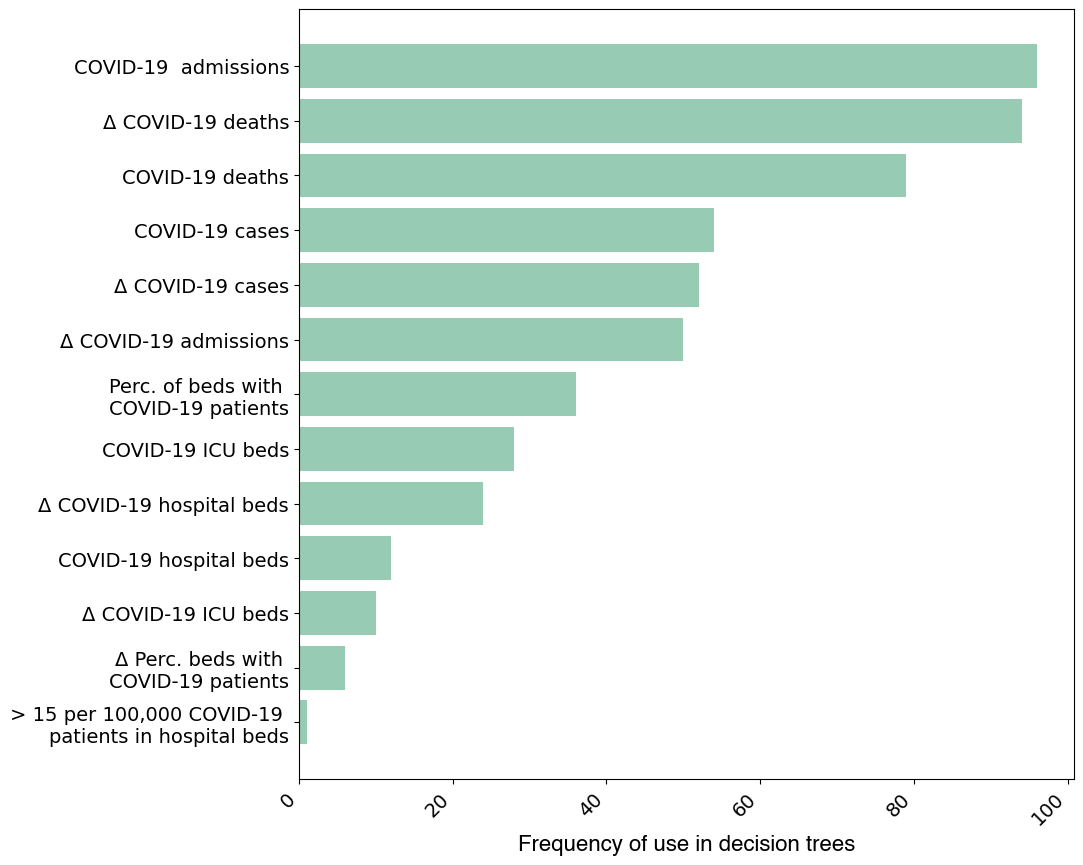

In [7]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10), facecolor='w', edgecolor='k', sharex='all', sharey='all')

sorted_feature_importance_counts = dict(sorted(feature_importance_counts.items(), key=lambda item: item[1], reverse=False))

# Convert dict_keys to list
keys_list = list(sorted_feature_importance_counts.keys())

plt.barh(keys_list, sorted_feature_importance_counts.values(), color='#98CBB4')
plt.xlabel('Frequency of use in decision trees', fontsize=16, **hfont)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig('/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/Included_features_expanding_models_full_shifted.png', dpi = 300,  bbox_inches="tight")


# Shapley calculation

In [8]:
shap_values_list = []

mean_shapley_values = []

size_of_test_dataset = 1
weeks_to_predict = range(1,117)
for prediction_week in weeks_to_predict:
    model_name_to_load = "Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    print(prediction_week)

    #period    

    X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_full = weights_full[0].to_numpy()
    clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full)

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full)
    y_pred_proba = clf_full_period.predict_proba(X_test_full)
        # Compute Shapley values for the current prediction
    explainer = shap.Explainer(clf_full_period)
    shap_values = explainer.shap_values(X_test_full)
    # Calculate the mean Shapley value importance

    mean_shapley_value = np.mean(shap_values[1], axis=0)
    mean_shapley_values.append(mean_shapley_value)
    #shap.summary_plot(shap_values[1], X_test_full, plot_type="bar", feature_names= feature_names)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116


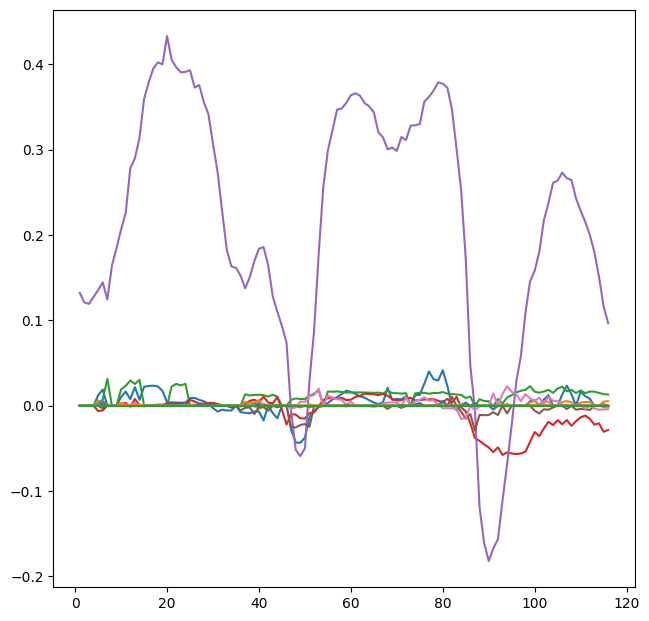

<Figure size 1200x600 with 0 Axes>

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 7.5), sharey = 'all')

#for i, feature in enumerate(feature_names):
#    axs.plot(weeks_to_predict, mean_shapley_values[i], linestyle='-', label = feature)
plt.plot(weeks_to_predict, mean_shapley_values, linestyle='-')
# Create a line chart to visualize feature importance
plt.figure(figsize=(12, 6))
#plt.plot(weeks_to_predict, mean_shapley_values, marker='o', linestyle='-')

plt.show()




In [11]:
fig, axs = plt.subplots(1,1, figsize=(15, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

feature_names=['COVID-19 cases','\u0394 COVID-19 cases', 'COVID-19 deaths', '\u0394 COVID-19 deaths', 'COVID-19  admissions', '\u0394 COVID-19 admissions', 'COVID-19 ICU beds', '\u0394 COVID-19 ICU beds',  'COVID-19 hospital beds', '\u0394 COVID-19 hospital beds', 'Perc. of beds with \nCOVID-19 patients', '\u0394 Perc. beds with \nCOVID-19 patients', '> 15 per 100,000 COVID-19 \npatients in hospital beds']
# Initialize empty lists to store mean Shapley values and prediction weeks
mean_shapley_values = []
prediction_weeks = []

size_of_test_dataset = 1
weeks_to_predict_sample = range(1,11)

for prediction_week in weeks_to_predict:
    model_name_to_load = "Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    print(f"Prediction Week: {prediction_week}")
    X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_full = weights_full[0].to_numpy()
    # Fit the model
    clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full)

    X_test_full.columns = feature_names

    explainer = shap.TreeExplainer(clf_full_period)
    shap_values = explainer.shap_values(X_test_full)
    #shap.summary_plot(shap_values, features = X_test_full.columns)
    explainer = shap.Explainer(clf_full_period)
    shap_values = explainer(X_test_full)
    # Concatenate all values
    if prediction_week == weeks_to_predict[0]:
        shap_values_all = shap_values
    else:
        for feature in X_test_full.columns: 
                shap_values_all.values = np.concatenate([shap_values_all.values, shap_values.values])
                shap_values_all.base_values = np.concatenate([shap_values_all.base_values, shap_values.base_values])
                shap_values_all.data = np.concatenate([shap_values_all.data, shap_values.data])

fig, axs = plt.subplots(1,1, figsize=(15, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

shap.plots.beeswarm(shap_values_all[:,:,1], max_display=14, show=False)
    #shap.summary_plot(shap_values, X_test_full, plot_type="bar", feature_names= feature_names)
#plt.savefig(f'/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/SHAP_values_full_expanding_train_models_shifted_{size_of_test_dataset}_week.png', dpi = 300)


Prediction Week: 1
Prediction Week: 2
Prediction Week: 3
Prediction Week: 4
Prediction Week: 5
Prediction Week: 6
Prediction Week: 7
Prediction Week: 8
Prediction Week: 9
Prediction Week: 10
Prediction Week: 11
Prediction Week: 12
Prediction Week: 13
Prediction Week: 14
Prediction Week: 15
Prediction Week: 16
Prediction Week: 17
Prediction Week: 18
Prediction Week: 19
Prediction Week: 20
Prediction Week: 21
Prediction Week: 22
Prediction Week: 23
Prediction Week: 24
Prediction Week: 25
Prediction Week: 26
Prediction Week: 27
Prediction Week: 28
Prediction Week: 29
Prediction Week: 30
Prediction Week: 31
Prediction Week: 32
Prediction Week: 33
Prediction Week: 34
Prediction Week: 35
Prediction Week: 36
Prediction Week: 37
